# NFTBank Data scientist Take-home Interview
## Part 2-1: Axie NFT의 1주 / 2주 / 1달간 윈도우 내에서 판매될 확률 예측 모델


#### 필요 라이브러리 import

In [24]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### 데이터 로드 및 형 변환 등
- 데이터 로드는 part1 코드와 동일하기 때문에 이 페이지 맨 하단에 있음
- axie NFT 거래와 특성 아이템, SLP 데이터를 모두 병합한 후, 거래가격 200달러 이하의 데이터만 분석
    - 거래와 특성 아이템의 block_date가 한 달 이내로 가까운 총 데이터의 약 80% 수준
- data 형태 
        - x data : 'breedCount', 'skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 
        'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points', 'total_mystic_parts_count', 
        'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness', 'exchange_rate' (14개)
        - x 중 multiple regression을 통해 유의미한 변수만 러프하게 셀렉을 먼저 하고자 하였으나, 실패
        - y data : 'erc20s_0_usd' (거래 당시 usd로 환산한 가격)
            - erc20 종류가 ETH, SLP 등 다양하고 cryptocurrency 가격변동을 제거하기 위해 usd로 환산한 가격을 사용
        

In [54]:
values = dataset.values
# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.tail(3))


        var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
910591   0.229994   0.285714   0.813953   0.672131        1.0   0.442623   
910592   0.229994   0.285714   0.813953   0.672131        1.0   0.442623   
910593   0.240203   0.285714   0.813953   0.672131        1.0   0.442623   

        var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var6(t)   var7(t)  \
910591   0.917355   0.958333    0.89916    0.942149  ...  0.442623  0.917355   
910592   0.917355   0.958333    0.89916    0.942149  ...  0.442623  0.917355   
910593   0.917355   0.958333    0.89916    0.942149  ...  0.442623  0.917355   

         var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  \
910591  0.958333  0.89916  0.942149       0.0       0.0       0.0  0.166667   
910592  0.958333  0.89916  0.942149       0.0       0.0       0.0  0.166667   
910593  0.958333  0.89916  0.942149       0.0       0.0       0.0  0.166667   

        var15(t)  
910591       0.0  
910592       0.0  


#### 데이터 train과 test set 나누기
- 가장 단순한 형태로 전체 중 20%를 test 데이터로 분류(추후 수정 필요)

In [55]:
from sklearn.model_selection import train_test_split

values = reframed.values
n_train = int(len(reframed) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(728474, 1, 29) (728474,) (182119, 1, 29) (182119,)


In [56]:
# Define LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Give a summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,611
Trainable params: 1,611
Non-trainable params: 0
_________________________________________________________________


In [57]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 728474 samples, validate on 182119 samples
Epoch 1/50


C:\Users\jeyeon\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


728474/728474 - 10s - loss: 0.0175 - val_loss: 0.0937
Epoch 2/50
728474/728474 - 10s - loss: 0.0182 - val_loss: 0.0908
Epoch 3/50
728474/728474 - 10s - loss: 0.0153 - val_loss: 0.0877
Epoch 4/50
728474/728474 - 10s - loss: 0.0125 - val_loss: 0.0830
Epoch 5/50
728474/728474 - 10s - loss: 0.0100 - val_loss: 0.0705
Epoch 6/50
728474/728474 - 10s - loss: 0.0072 - val_loss: 0.0740
Epoch 7/50
728474/728474 - 10s - loss: 0.0070 - val_loss: 0.0728
Epoch 8/50
728474/728474 - 10s - loss: 0.0062 - val_loss: 0.0695
Epoch 9/50
728474/728474 - 10s - loss: 0.0055 - val_loss: 0.0668
Epoch 10/50
728474/728474 - 10s - loss: 0.0050 - val_loss: 0.0642
Epoch 11/50
728474/728474 - 10s - loss: 0.0044 - val_loss: 0.0608
Epoch 12/50
728474/728474 - 9s - loss: 0.0039 - val_loss: 0.0577
Epoch 13/50
728474/728474 - 9s - loss: 0.0033 - val_loss: 0.0562
Epoch 14/50
728474/728474 - 9s - loss: 0.0031 - val_loss: 0.0564
Epoch 15/50
728474/728474 - 9s - loss: 0.0029 - val_loss: 0.0559
Epoch 16/50
728474/728474 - 9s - l

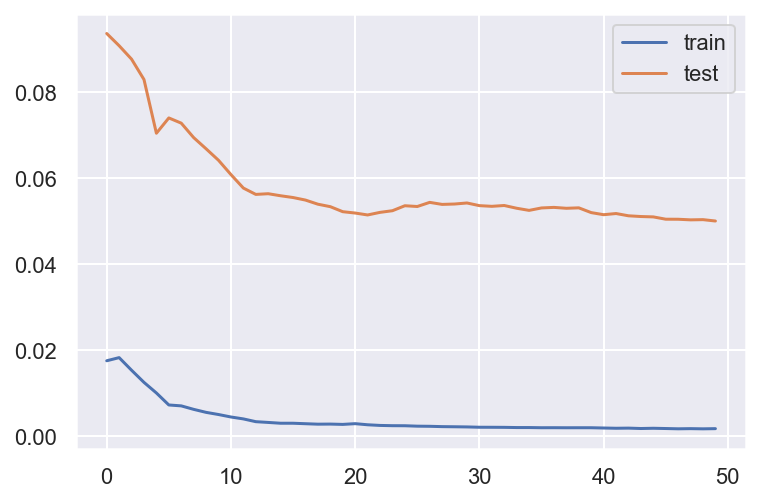

In [58]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 모형 평가

#### 아래는 axie 데이터 로드 

In [ ]:
# axie 데이터 로드

In [16]:
from sqlalchemy import create_engine

with open("db_info.txt") as f:
    lines = f.readlines()
    db_id = lines[0].strip()
    db_pwd = lines[1].strip()
    db_ip = lines[2].strip()
    db_port = lines[3].strip()

class Engine:

    def __init__(self, db_ip = db_ip, db_port = db_port, db_id = db_id, db_pwd = db_pwd):
        self.db_ip = db_ip
        self.db_port = db_port
        self.db_id = db_id
        self.db_pwd = db_pwd

    def connect(self, db_name):
        conn = create_engine(
            "mysql+mysqldb://" + self.db_id + ":" + self.db_pwd + "@" + self.db_ip + ":" + self.db_port + "/" + db_name,
            encoding='utf-8')
        return conn  

In [ ]:
def get_axie_merged_df(type='sent'):
    engine = Engine()
    conn = engine.connect('axie')
    sql = "select af.block_timestamp as transaction_timestamp, af.nft_transaction_hash, af.event_type, " \
          "af.transaction_type, af.transaction_subtype,af.nft_transfer_type, af.nft_transfer_subtype, af.items_sent_0_item_id, " \
          "af.items_received_0_item_id, af.items_sent_count, af.items_received_count, " \
          "af.erc20s_0_symbol, af.erc20s_0_sent_amount, af.erc20s_0_received_amount, af.erc20s_0_sent_usd, af.erc20s_0_received_usd, " \
          "af.gas_used_usd, ai.block_timestamp as item_timestamp, ai.item_id, ai.class, ai.stage, ai.level, ai.exp, ai.breedable, ai.breedCount, " \
          "ai.skill, ai.morale, ai.speed, ai.hp, ai.all_parts_total_points, ai.mouth_move_stage, ai.mouth_move_total_points, " \
          "ai.horn_move_stage, ai.horn_move_total_points, ai.back_move_stage, ai.back_move_total_points,ai.tail_move_stage, " \
          "ai.tail_move_total_points, ai.total_mystic_parts_count, ai.total_bionic_parts_count, ai.total_xmas_parts_count, ai.pureness " \
          "from axie.axie_financials af, axie.axie_items ai " \
          "where datediff(af.block_timestamp, ai.block_timestamp) between -30 and 30 and af.data_consistency_status = 'complete' "
    if type == 'sent':
        sql += "and af.items_sent_0_item_id  = ai.item_id order by ai.item_id"
    elif type == 'received':
        sql += "and af.items_received_0_item_id  = ai.item_id order by ai.item_id"
    else:
        print('타입을 잘못 입력하였습니다.')
        return 0
    data = conn.execute(sql).fetchall()

    conn.dispose()
    axie_df = pd.DataFrame(data, columns=['transaction_timestamp', 'nft_transaction_hash', 'event_type',
          'transaction_type', 'transaction_subtype','nft_transfer_type', 'nft_transfer_subtype', 'items_sent_0_item_id',
          'items_received_0_item_id', 'items_sent_count', 'items_received_count',
          'erc20s_0_symbol', 'erc20s_0_sent_amount', 'erc20s_0_received_amount', 'erc20s_0_sent_usd', 'erc20s_0_received_usd',
          'gas_used_usd', 'item_timestamp', 'item_id', 'class', 'stage', 'level', 'exp', 'breedable', 'breedCount',
          'skill', 'morale', 'speed', 'hp', 'all_parts_total_points', 'mouth_move_stage', 'mouth_move_total_points',
          'horn_move_stage', 'horn_move_total_points', 'back_move_stage', 'back_move_total_points','tail_move_stage',
          'tail_move_total_points', 'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness'])

    # 결측치 처리
    numeric_cols = ['erc20s_0_sent_amount', 'erc20s_0_received_amount', 'erc20s_0_sent_usd', 'erc20s_0_received_usd',
          'gas_used_usd', 'exp', 'breedCount', 'skill', 'morale', 'speed', 'hp', 'all_parts_total_points', 'mouth_move_total_points',
          'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points',
            'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness' ]
    axie_df[numeric_cols] = axie_df[numeric_cols].fillna(0)
    axie_df = axie_df.astype({'transaction_timestamp': 'datetime64', 'items_sent_count':'int', 'items_received_count':'int',
                              'erc20s_0_sent_amount':'float64',
                              'erc20s_0_received_amount':'float64', 'erc20s_0_sent_usd':'float64', 'erc20s_0_received_usd':'float64',
                              'gas_used_usd':'float64', 'item_timestamp':'datetime64', 'stage':'int', 'level':'int', 'exp':'int','breedCount':'int',
                              'skill':'int', 'morale':'int', 'speed':'int', 'hp':'int', 'all_parts_total_points':'int', 'mouth_move_total_points':'int',
                              'horn_move_total_points':'int', 'back_move_total_points':'int', 'tail_move_total_points':'int',
                              'total_mystic_parts_count':'int', 'total_bionic_parts_count':'int', 'total_xmas_parts_count':'int', 'pureness':'int'})
    return axie_df


def get_SLP_df():
    engine = Engine()
    conn = engine.connect('axie')
    sql = "select block_date, exchange_rate from axie.erc20_fx where currency='SLP' and vs_currency='ETH' order by block_date"
    data = conn.execute(sql).fetchall()
    conn.dispose()
    df = pd.DataFrame(data, columns=['block_date', 'exchange_rate'])
    df = df.astype({'block_date': 'datetime64', 'exchange_rate':'float64'})
    return df

In [50]:
axie_sent_df = get_axie_merged_df(type='sent')
axie_received_df = get_axie_merged_df(type='received')
SLP_df = get_SLP_df()

In [51]:
axie_sent_df['erc20s_0_amount'] = axie_sent_df['erc20s_0_received_amount'].copy()
axie_sent_df['erc20s_0_usd'] = axie_sent_df['erc20s_0_received_usd'].copy()
axie_received_df['erc20s_0_amount'] =-axie_received_df['erc20s_0_sent_amount'].copy()
axie_received_df['erc20s_0_usd'] = -axie_received_df['erc20s_0_sent_usd'].copy()
axie_sent_df.drop(['items_sent_0_item_id','items_received_0_item_id', 'items_sent_count', 'items_received_count', 
                  'erc20s_0_sent_amount', 'erc20s_0_received_amount','erc20s_0_sent_usd', 'erc20s_0_received_usd',], axis=1, inplace=True)
axie_received_df.drop(['items_sent_0_item_id','items_received_0_item_id', 'items_sent_count', 'items_received_count', 
                  'erc20s_0_sent_amount', 'erc20s_0_received_amount','erc20s_0_sent_usd', 'erc20s_0_received_usd',], axis=1, inplace=True)
axie_df = pd.concat([axie_sent_df, axie_received_df], axis=0)

# transaction_date 추가
axie_df['transaction_date'] = pd.to_datetime(axie_df['transaction_timestamp']).dt.date
axie_df['transaction_date'] = pd.to_datetime(axie_df['transaction_date'])

# 시간대별로 정렬 (중요*)
axie_df = axie_df.sort_values('transaction_timestamp')

In [52]:
# axie_df와 SLP를 합친다
axie_df = pd.merge(axie_df, SLP_df, how='left', left_on='transaction_date', right_on='block_date')

In [53]:
col = ['erc20s_0_usd','breedCount', 'skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 
        'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points', 'total_mystic_parts_count', 
        'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness', 'exchange_rate']

axie_df_under_200 = axie_df[axie_df['erc20s_0_usd'] < 200]
dataset = axie_df_under_200[col]